In [75]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import matplotlib
# matplotlib.font_manager._rebuild()
# plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
%matplotlib inline

In [2]:
import sys
sys.path.append("/notebooks/nb_IEEE/opmap/")

In [3]:
import opmap
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.apdMap import APDMap
from opmap.phaseMapHilbert import PhaseMapHilbert as PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

In [4]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

In [5]:
def isochronal(pmap, threshold):
    contour = np.zeros_like(pmap.data)

    for i in range(contour.shape[1]):
        for j in range(contour.shape[2]):        
            if pmap.roi[i,j] == 1:
                counter = 0
                for time in range(contour.shape[0]):
                    if time == 0:
                        pass
                    elif ((pmap.data[time-1, i, j] < threshold) * (pmap.data[time, i, j] > threshold)) == 1:
                        counter = 0

                    contour[time, i, j] = counter
                    counter += 1
                
    return contour

## 旋回興奮に対する冷却

In [6]:
import cv2

### 20181220-1/C001H001S0012

In [76]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181220-1/C001H001S0012/')
print(data_path)
start = 9500
end = 11000
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/ROI.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=50)
vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/


In [77]:
for i in range(1500):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/jet/vmem/%s.png' % "{0:04d}".format(i),
               vmem.data[i, :, :], vmin=-0.3, vmax=0.3, cmap=vmem.cmap)

In [78]:
pmap = PhaseMap(vmem)

In [79]:
PhaseVarianceMap?

In [129]:
pvmap = PhaseVarianceMap(pmap, size=9)

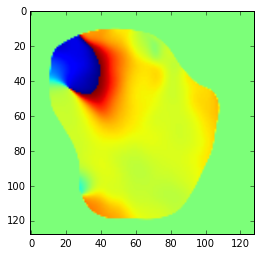

In [128]:
pmap.showFrame(880)

In [168]:
pvmap.data.shape

(1500, 128, 128)

In [178]:
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/raw.png',
           raw.data[0, :, :], cmap=raw.cmap)

In [175]:
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/trajectory.png',
           np.sum(pvmap.data[880:900, :, :], axis=0) > 3, cmap='gray')

In [190]:
im_rgb = Image.open('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/trajectory.png')
im_rgba = im_rgb.copy()
im_rgba.putalpha(128)
im_data = np.array(im_rgba)

for i in range(128):
    for j in range(128):
        if im_data[i,j,0] < 128:
            im_data[i,j,3] = 0
        else:
            im_data[i,j,3] = 255
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/alpha_trajectory.png',
       im_data, cmap='gray')
plt.close()

In [221]:
def vmem_denoise(vmem):
    data = scipy.ndimage.filters.gaussian_filter1d(vmem, sigma=5)
    return (data-np.min(data))/(np.max(data)-np.min(data))

In [229]:
plt.subplot(4,1,1)
plt.plot(vmem_denoise(vmem.data[850:930, 40, 60]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,2)
plt.plot(vmem_denoise(vmem.data[850:930, 60, 90]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,3)
plt.plot(vmem_denoise(vmem.data[850:930, 80, 120]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,4)
plt.plot(vmem_denoise(vmem.data[850:930, 100, 150]))
plt.xticks([10, 30, 50, 70], [20.7, 20.74, 20.78, 20.82])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/vmem_comparizon.png')
plt.close()

In [191]:
hoge = copy.deepcopy(im_data)

In [231]:
test = copy.deepcopy(hoge)
test[18:22,28:32, :] = 0
test[28:32,43:47, :] = 0
test[38:42,58:62, :] = 0
test[48:52,73:77, :] = 0
test[18:22,28:32, 3] = 255
test[28:32,43:47, 3] = 255
test[38:42,58:62, 3] = 255
test[48:52,73:77, 3] = 255

plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/vmem_points.png',
           test, cmap='gray')
plt.close()

In [131]:
for i in range(1500):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/gray/pvmap/%s.png' % "{0:04d}".format(i),
               pvmap.data[i, :, :], vmin=0, vmax=1, cmap=pvmap.cmap)

In [149]:
from PIL import Image

for time in range(1500):
    im_rgb = Image.open('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/gray/pvmap/%s.png'%  "{0:04d}".format(time))
    im_rgba = im_rgb.copy()
    im_rgba.putalpha(128)
    im_data = np.array(im_rgba)

    for i in range(128):
        for j in range(128):
            if im_data[i,j,0] < 128:
                im_data[i,j,3] = 0
            else:
                im_data[i,j,3] = 255
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/gray/alpha_pvmap/%s.png' % "{0:04d}".format(time),
           im_data, cmap=pvmap.cmap)
    plt.close()

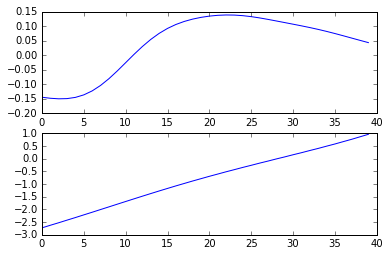

In [68]:
plt.subplot(2,1,1)
plt.plot(vmem.data[240:280, 128, 128])
plt.subplot(2,1,2)
plt.plot(pmap.data[240:280, 64, 64])

In [390]:
import copy

for i in range(1000):
    dat = copy.deepcopy(pmap.data[i]) - 1
    dat = dat +(dat < -np.pi)*2*np.pi

    pmap.data[i] = dat * pmap.roi

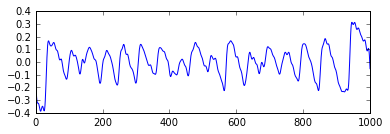

In [502]:
plt.subplot(2,1,1)
plt.plot(vmem.data[:, 128, 128])
# plt.subplot(2,1,2)
# plt.plot(pmap.data[200:400, 64, 64])

In [83]:
isochronal_data = isochronal(pmap, 2.9)

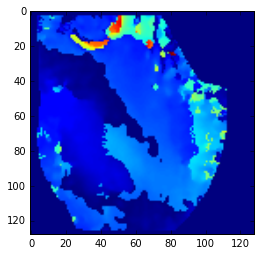

In [436]:
plt.imshow(isochronal_data[300])

In [437]:
for i in range(500):
    time = i + 500
    plt.subplot(1,3,1)
    plt.imshow(vmem.data[time], cmap=vmem.cmap, vmin=-0.3, vmax=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(pmap.data[time], cmap=pmap.cmap)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(isochronal_data[time])
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-10500/jet/isochronal/%s.png' % "{0:04d}".format(i))
    plt.close()

In [88]:
from scipy import ndimage
import copy
import scipy

In [105]:
data = copy.deepcopy(isochronal_data[900])
data = ndimage.gaussian_filter(data, 3) * pmap.roi
data = scipy.signal.medfilt2d(data, 19)

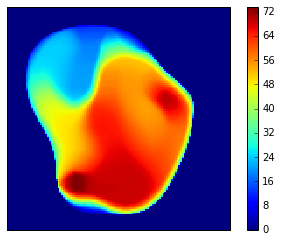

In [106]:
plt.imshow(data, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [107]:
contour_data = np.zeros_like(data)

for i in range(128):
    for j in range(128):
        if data[i,j] % 4 < 0.5 or data[i,j] % 4 > 3.5:
            contour_data[i,j] = data[i,j]
        else:
            pass

In [113]:
roi_start = cv2.resize(vmem.roi, (128, 128))
kernel = np.ones((5,5),np.uint8)
roi_foriso = cv2.erode(roi_start, kernel, iterations = 2)

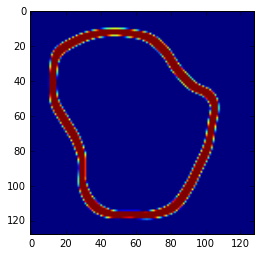

In [114]:
plt.imshow(roi_start - roi_foriso)

In [167]:
im_rgb = Image.open('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/gray/pvmap/0000.png')
im_rgba = im_rgb.copy()
im_rgba.putalpha(128)
im_data = np.array(im_rgba)

for i in range(128):
    for j in range(128):
        im_data[i,j,:] = 0
        im_data[i,j,3] = 255
        if contour_data[i,j] > 1:
            im_data[i,j,:] = 255
            im_data[i,j,3] = 0
            
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/mask.png', im_data, cmap='gray')

In [163]:
plt.imshow(contour_data * roi_foriso, interpolation='nearest')
# plt.imshow(contour_data, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/isochronal.png', contour_data)
plt.close()